<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="250" align="center">

**PROCESAMIENTO DE LENGUAJE NATURAL**

*DESAFÍO Nº4 - PREDICCIÓN DE PALABRA - JUAN I. MUNAR*


El objetivo es utilizar documentos / corpus para crear embeddings de palabras en un contexto utilizando la layer Embedding de Keras. Se utilizarán esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

**1. LIBRERÍAS**

In [ ]:
# Varios Python
import random
import io
import pickle
import string

# Lectura y parseo
import bs4 as bs
import urllib.request

# Procesamiento y ploteo
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Redes
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional

**2. DATOS**

In [ ]:
# Función para obtener el texto con bs y urllib
def texto(URL):
  raw_html = urllib.request.urlopen(URL)
  raw_html = raw_html.read()

  # Parsear artículo, 'lxml' es el parser a utilizar
  text_html = bs.BeautifulSoup(raw_html, 'lxml')

  # Encontrar todos los párrafos del HTML (bajo el tag <p>)
  # y tenerlos disponible como lista
  text_paragraphs = text_html.find_all('p')

  text_salida = ''

  for para in text_paragraphs:
      text_salida += para.text

  return text_salida

# De textos.info obtengo La Metamorfosis de Kafka porque es una novela corta.
# Este mismo código se ensayó con otros textos de mayor longitud, lo que colapsa el RAM del Colab ~12GB
corpus = texto('https://www.textos.info/franz-kafka/la-metamorfosis/ebook')

In [ ]:
# Primer preprocesamiento del texto
def preprocess_clean_text(text):

    # Sacar saltos de línea
    text = re.sub( r'\r\n', ' ', text)
    # Quitar caracteres especiales
    text = re.sub(r'[«»!¡¿?\-]', '', text)
    # Quitar espacios innecesarios
    text = re.sub(r'\s+', ' ', text)

    return text

# Preproceso y visualizo
corpus = preprocess_clean_text(corpus)
corpus

'Cuando Gregorio Samsa se despertó una mañana después de un sueño intranquilo, se encontró sobre su cama convertido en un monstruoso insecto. Estaba tumbado sobre su espalda dura, y en forma de caparazón y, al levantar un poco la cabeza veía un vientre abombado, parduzco, dividido por partes duras en forma de arco, sobre cuya protuberancia apenas podía mantenerse el cobertor, a punto ya de resbalar al suelo. Sus muchas patas, ridículamente pequeñas en comparación con el resto de su tamaño, le vibraban desamparadas ante los ojos.Qué me ha ocurrido, pensó.No era un sueño. Su habitación, una auténtica habitación humana, si bien algo pequeña, permanecía tranquila entre las cuatro paredes harto conocidas. Por encima de la mesa, sobre la que se encontraba extendido un muestrario de paños desempaquetados —Samsa era viajante de comercio—, estaba colgado aquel cuadro que hacía poco había recortado de una revista y había colocado en un bonito marco dorado. Representaba a una dama ataviada con un

**3. PREPROCESAMIENTO**

In [ ]:
# Funciones y clases de keras
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

In [ ]:
# Para ocupar menos RAM, defino una función que transforma el corpus
def xy(corpus, train_len):
    """
          args:
              corpus (string): string con corpus concatenado
              train_len (int): largo de la secuencia
    """
  # Transformar el corpus a tokens
    tokens = text_to_word_sequence(corpus)

   # Código para hacer el desfasaje de las palabras
    text_sequences = []
    for i in range(train_len, len(tokens)):
      seq = tokens[i-train_len:i]
      text_sequences.append(seq)

    # Proceso de tokenización
    tok = Tokenizer()
    tok.fit_on_texts(text_sequences)

    # Convertimos las palabras a números
    sequences = tok.texts_to_sequences(text_sequences)

    # Obtener arrays para slicing
    arr_sequences = np.array(sequences)
    x_data = arr_sequences[:,:-1]
    y_data_int = arr_sequences[:,-1]

    # Cantidad de palabras en el vocabulario
    vocab_size = len(tok.word_counts)

    # One Hot Encoding
    y_data_int_offset = y_data_int - 1
    y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)

    return x_data, y_data, vocab_size, tok

In [ ]:
# Obtenemos los valores
x_data, y_data, vocab_size,tok = xy(corpus, train_len=4)

# Elimino el corpus por RAM
del corpus

**4. ENTRENAMIENTO**

In [ ]:
# Largo de la secuencia de entrada
input_seq_len = x_data.shape[1]
input_seq_len

3

In [ ]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3671

In [ ]:
# Defino el modelo
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size
model.add(Embedding(input_dim=vocab_size+1, output_dim=10, input_length=input_seq_len))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 3, 10)             36720     
                                                                 
 bidirectional_1 (Bidirecti  (None, 3, 128)            38400     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 3, 128)            98816     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_6 (LSTM)               (None, 64)               

In [ ]:
hist = model.fit(x_data, y_data, epochs=100, validation_split=0.2)

Epoch 1/100
522/522 [==============================] - 27s 31ms/step - loss: 6.6079 - accuracy: 0.0449 - val_loss: 6.5168 - val_accuracy: 0.0508
Epoch 2/100
522/522 [==============================] - 11s 21ms/step - loss: 6.1204 - accuracy: 0.0468 - val_loss: 6.6504 - val_accuracy: 0.0383
Epoch 3/100
522/522 [==============================] - 10s 19ms/step - loss: 6.0175 - accuracy: 0.0520 - val_loss: 6.7295 - val_accuracy: 0.0498
Epoch 4/100
522/522 [==============================] - 11s 22ms/step - loss: 5.8425 - accuracy: 0.0667 - val_loss: 6.7941 - val_accuracy: 0.0604
Epoch 5/100
522/522 [==============================] - 11s 20ms/step - loss: 5.6268 - accuracy: 0.0776 - val_loss: 6.8518 - val_accuracy: 0.0731
Epoch 6/100
522/522 [==============================] - 11s 22ms/step - loss: 5.4750 - accuracy: 0.0834 - val_loss: 7.0297 - val_accuracy: 0.0714
Epoch 7/100
522/522 [==============================] - 10s 19ms/step - loss: 5.3514 - accuracy: 0.0905 - val_loss: 7.1331 - val_ac

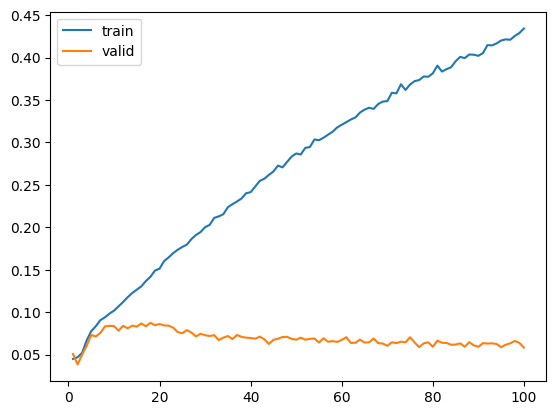

In [ ]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

**5. PREDICCIÓN**

Predicción de la próxima palabra

In [ ]:
def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]

    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word


In [ ]:
model_response('es un hombre')

1/1 [==============================] - 2s 2s/step


'es un hombre cansado'

In [ ]:
model_response('es un hombre cansado')

1/1 [==============================] - 0s 41ms/step


'es un hombre cansado todos'

In [ ]:
model_response('es un hombre cansado todos')

1/1 [==============================] - 0s 39ms/step


'es un hombre cansado todos o'

**6. GENERACIÓN DE NUEVAS SECUENCIAS**

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text

	  # Generate a fixed number of words
    for _ in range(n_words):

		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]

		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)

		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word

    return output_text

In [ ]:
input_text='es un hombre'

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 36ms/step


'es un hombre cansado todos o disposición'

In [ ]:
input_text='gregorio tiene un'

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 35ms/step


'gregorio tiene un resbaló padres el esperado'

**7. BEAM SEARCH Y MUESTREO ALEATORIO**

In [ ]:
# Funcionalidades para hacer encoding y decoding
def encode(text,max_length=3):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

from scipy.special import softmax

# Función que selecciona candidatos para el Beam Search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # Colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # Criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # Beam Search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]),
                                num_beams,
                                p=softmax(pred_large/temp)) # Beam Search con muestreo

  # Traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # Devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # First iteration

    # Encode
    encoded = encode(input)

    # First prediction
    y_hat = np.squeeze(model.predict(encoded))

    # Get vocabulary size
    vocab_size = y_hat.shape[0]

    # Initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # Select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # Beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # Actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # Predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [ ]:
# Predicción con Beam Search
salidas = beam_search(model,num_beams=10,num_words=6,input="metamorfosis")

1/1 [==============================] - 0s 34ms/step


In [ ]:
# Veamos las salidas
decode(salidas[0])

['disculpa cuarto la gran tendría']

**8. CONCLUSIONES**

El funcionamiento del modelo es malo. Hay una gran limitante por disponibilidad de RAM en el Colab. Corpus grandes saturan la RAM en el entrenamiento, corpus chicos presentan problemas de falta de datos.

El uso de capas bidireccionales mejoró levemente el funcionamiento. El uso de una mayor cantidad de capas no cambió sustancialmente los resultados.